In [121]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("DATA/farms_train.csv", sep=';', decimal=',',encoding='utf-8-sig',)
data_test = pd.read_csv("DATA/farms_test.csv", sep=',', header=0, dtype=str)
object_columns = data.select_dtypes(include=['object']).columns

for col in object_columns:
    data[col] = data[col].str.replace(',', '.').str.strip()  
    data[col] = pd.to_numeric(data[col], errors='coerce')   

print(data.dtypes)

DIFF      int64
R2      float64
R7      float64
R8      float64
R17     float64
R22     float64
R32     float64
dtype: object


In [123]:
data.head()

,DIFF,R2,R7,R8,R17,R22,R32
0,0,0.705,0.290,0.1334,0.0481,0.5258,0.2941
1,1,0.801,0.213,0.1282,0.0186,2.1411,0.3005
2,1,0.591,0.429,0.2999,0.0800,0.5957,0.4126
3,0,0.373,0.346,1.3704,0.0812,0.3430,0.2265
4,0,0.000,1.417,0.2493,0.0501,0.8728,0.1086


<Figure size 1400x800 with 0 Axes>

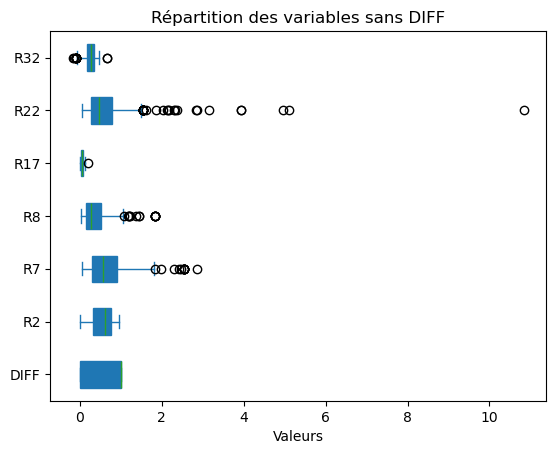

In [125]:
# Visualisation avec des boîtes à moustaches
plt.figure(figsize=(14, 8))
data.plot(kind='box', vert=False, patch_artist=True, showfliers=True)
plt.xlabel('Valeurs')
plt.title('Répartition des variables sans DIFF')
plt.show()

In [126]:
data.R22.describe()

count    398.000000
mean       0.673835
std        0.797979
min        0.055390
25%        0.285525
50%        0.480500
75%        0.782050
max       10.840000
Name: R22, dtype: float64

In [129]:
idR22 = data.R22.idxmax()
data = data.drop(49)

In [131]:
data.R22.describe()

count    397.000000
mean       0.648228
std        0.613786
min        0.055390
25%        0.285200
50%        0.479300
75%        0.779800
max        5.110900
Name: R22, dtype: float64

<Figure size 1400x800 with 0 Axes>

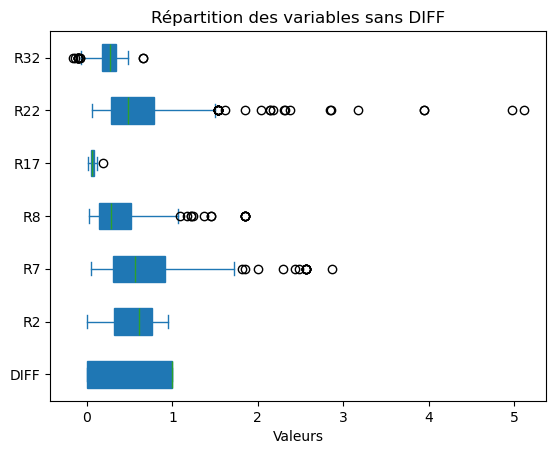

In [133]:
# Visualisation avec des boîtes à moustaches
plt.figure(figsize=(14, 8))
data.plot(kind='box', vert=False, patch_artist=True, showfliers=True)
plt.xlabel('Valeurs')
plt.title('Répartition des variables sans DIFF')
plt.show()

In [134]:
X = data.drop(columns=['DIFF'])
y = data['DIFF']

# Séparation des données des ensembles d'entraînement et de test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

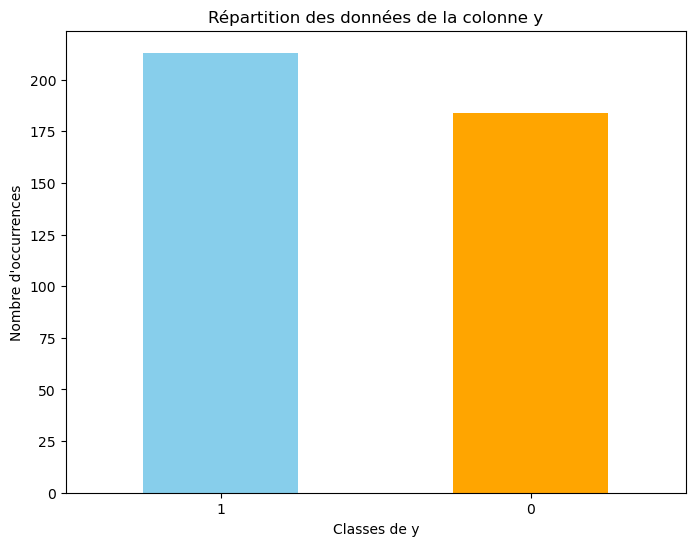

In [149]:
plt.figure(figsize=(8, 6))
y.value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.xlabel('Classes de DIFF')
plt.ylabel('Nombre d\'occurrences')
plt.title('Répartition des données de la colonne DIFF')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Définir la grille d'hyperparamètres
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10], 
    'solver': ['saga', 'liblinear', 'lbfgs'],
    'max_iter': [100, 200, 500],
}

- C : Contrôle le compromis entre l'ajustement des données et la régularisation. Plus C est grand, plus le modèle est tolérant au bruit dans les données d'entraînement et peut donc bien s'ajuster, mais à un risque de surajustement.
- solver : Algorithme utilisé pour minimiser la fonction de perte lors de l'entraînement. Il sélectionne la méthode d'optimisation la plus appropriée en fonction des données. 'saga' est rapide pour des données très grandes, 'liblinear' est idéal pour des données linéairement séparables, et 'lbfgs' est performant pour des données bien conditionnées.
- max_iter : Nombre maximal d'itérations que le solver est autorisé à exécuter pour converger. Un nombre plus élevé permet au modèle de converger plus profondément, mais peut augmenter le temps d'entraînement, tandis qu'un nombre faible peut arrêter prématurément l'entraînement.
- penalty : Détermine la régularisation utilisée par le modèle, influençant la magnitude des coefficients en les rendant plus ou moins contraints. Par exemple, 'l1' utilise une pénalité L1 pour réduire les coefficients à zéro, tandis que 'l2' utilise une pénalité L2 qui réduit la taille des coefficients sans les rendre nuls

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Meilleurs paramètres : {'C': 10, 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga'}
Meilleure AUC : 0.9334759358288771


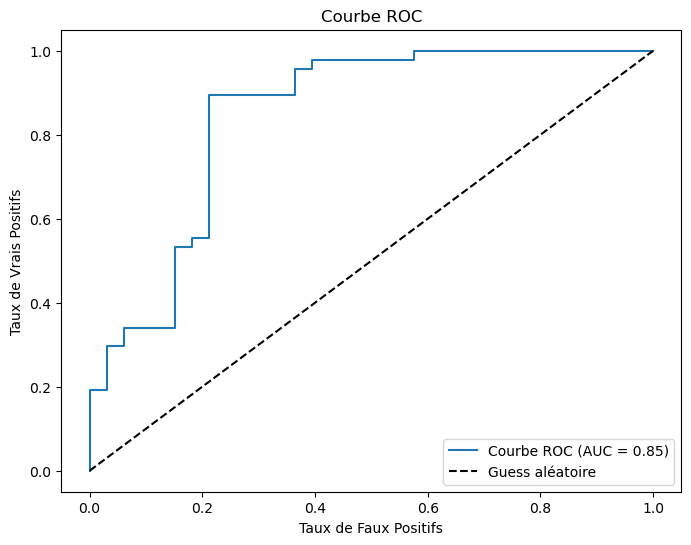

In [143]:
# Initialiser le modèle
model = LogisticRegression()

# Recherche de grille
grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5, verbose=1)
grid_search.fit(X_train, y_train)

# Meilleurs paramètres et score
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleure AUC :", grid_search.best_score_)

# Prédictions sur le jeu de validation
best_model = grid_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

# Tracé de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
auc = roc_auc_score(y_val, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Courbe ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Guess aléatoire')
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC')
plt.legend()
plt.show()